# Deep learning in Human Language Technology Project

- Students names: Momina Iffat Iftikhar, Muhammad Junaid Raza
- Date: 12th Nov, 2025
- Chosen Corpus: Rotten Tomatoes
- Contributions (if group project):

### Corpus information

- Description of the chosen corpus: Movie Review Dataset containing 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews for binary sentiment classification.
- Paper(s) and other published materials related to the corpus: Bo Pang and Lillian Lee, "Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales", Proceedings of the ACL, 2005.
- Random baseline performance and expected performance for recent machine learned models: Random baseline: 50% (binary classification). Expected SOTA performance: ~85-90% accuracy based on transformer models.

---

## 1. Setup

In [2]:
# Install required libraries
!pip install -q transformers datasets accelerate evaluate scikit-learn

# Import libraries
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import evaluate
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


---

## 2. Data download, sampling and preprocessing

### 2.1. Download the corpus

In [3]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")

print("Dataset loaded successfully!")
print(f"\nDataset structure: {dataset}")
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['validation'])}")
print(f"Test set size: {len(dataset['test'])}")

Dataset loaded successfully!

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Train set size: 8530
Validation set size: 1066
Test set size: 1066


### 2.2. Sampling and preprocessing

In [4]:
# Display dataset examples
print("="*60)
print("Sample examples from training set:")
print("="*60)
for i in range(3):
    example = dataset['train'][i]
    label_name = "positive" if example['label'] == 1 else "negative"
    print(f"\nExample {i+1}:")
    print(f"Text: {example['text']}")
    print(f"Label: {label_name} ({example['label']})")

# Check label distribution
print("\n" + "="*60)
print("Label distribution in each split:")
print("="*60)

for split_name in ['train', 'validation', 'test']:
    labels = [example['label'] for example in dataset[split_name]]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name.capitalize()} set:")
    print(f"  Total samples: {len(labels)}")
    print(f"  Negative (0): {counts[0]} ({counts[0]/len(labels)*100:.2f}%)")
    print(f"  Positive (1): {counts[1]} ({counts[1]/len(labels)*100:.2f}%)")

# Text length statistics
print("\n" + "="*60)
print("Text length statistics (in words):")
print("="*60)

for split_name in ['train', 'validation', 'test']:
    lengths = [len(example['text'].split()) for example in dataset[split_name]]
    print(f"\n{split_name.capitalize()} set:")
    print(f"  Mean length: {np.mean(lengths):.2f} words")
    print(f"  Min length: {np.min(lengths)} words")
    print(f"  Max length: {np.max(lengths)} words")
    print(f"  Median length: {np.median(lengths):.2f} words")

Sample examples from training set:

Example 1:
Text: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Label: positive (1)

Example 2:
Text: the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
Label: positive (1)

Example 3:
Text: effective but too-tepid biopic
Label: positive (1)

Label distribution in each split:

Train set:
  Total samples: 8530
  Negative (0): 4265 (50.00%)
  Positive (1): 4265 (50.00%)

Validation set:
  Total samples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)

Test set:
  Total samples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)

Text length statistics (in words):

Train set:
  Mean length: 20.99 words
  Min length: 1 words
 

---

## 3. Prompting a generative model

### 3.1 Prompt optimization

In [6]:
# Load SmolLM-135M-Instruct for prompting
model_name_gen1 = "HuggingFaceTB/SmolLM-135M-Instruct"

print(f"Loading {model_name_gen1}...")
tokenizer_gen1 = AutoTokenizer.from_pretrained(model_name_gen1)
model_gen1 = AutoModelForCausalLM.from_pretrained(
    model_name_gen1,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Set padding token if not already set
if tokenizer_gen1.pad_token is None:
    tokenizer_gen1.pad_token = tokenizer_gen1.eos_token
    model_gen1.config.pad_token_id = model_gen1.config.eos_token_id

print(f"Model loaded successfully!")
print(f"Model parameters: {model_gen1.num_parameters() / 1e6:.2f}M")
print(f"Model device: {model_gen1.device}")

Loading HuggingFaceTB/SmolLM-135M-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Model loaded successfully!
Model parameters: 134.52M
Model device: cuda:0


In [7]:
# Define different prompt templates to test
prompt_templates = {
    "simple": "Classify the sentiment of this movie review as positive or negative.\n\nReview: {text}\nSentiment:",

    "instructional": "You are a sentiment analysis assistant. Classify the following movie review as either 'positive' or 'negative'.\n\nReview: {text}\n\nAnswer with only 'positive' or 'negative'.\nSentiment:",

    "concise": "Movie review: {text}\nSentiment (positive/negative):",

    "detailed": "Task: Analyze the sentiment of the movie review below.\nInstructions: Respond with exactly one word - either 'positive' or 'negative'.\n\nReview: {text}\n\nSentiment:"
}

# Display the templates
print("Prompt templates defined:")
for name, template in prompt_templates.items():
    print(f"\n{name.upper()}:")
    print("-" * 60)
    print(template[:150] + "..." if len(template) > 150 else template)

Prompt templates defined:

SIMPLE:
------------------------------------------------------------
Classify the sentiment of this movie review as positive or negative.

Review: {text}
Sentiment:

INSTRUCTIONAL:
------------------------------------------------------------
You are a sentiment analysis assistant. Classify the following movie review as either 'positive' or 'negative'.

Review: {text}

Answer with only 'pos...

CONCISE:
------------------------------------------------------------
Movie review: {text}
Sentiment (positive/negative):

DETAILED:
------------------------------------------------------------
Task: Analyze the sentiment of the movie review below.
Instructions: Respond with exactly one word - either 'positive' or 'negative'.

Review: {text}
...


In [8]:
def generate_prediction(model, tokenizer, text, prompt_template, max_new_tokens=10):
    """
    Generate prediction for a single text using the given prompt template.
    """
    # Format the prompt
    prompt = prompt_template.format(text=text)

    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,  # Low temperature for more deterministic output
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode only the generated part (not the prompt)
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    return generated_text.strip()


def extract_label(generated_text):
    """
    Extract label from generated text. Returns 1 for positive, 0 for negative, None if unclear.
    """
    generated_lower = generated_text.lower()

    # Check first 20 characters for the label
    first_part = generated_lower[:20]

    if "positive" in first_part:
        return 1
    elif "negative" in first_part:
        return 0
    else:
        # If not found in first part, check the whole text
        if "positive" in generated_lower:
            return 1
        elif "negative" in generated_lower:
            return 0
        else:
            return None  # Failed to extract


def evaluate_prompting(model, tokenizer, dataset_split, prompt_template, num_samples=100, seed=42):
    """
    Evaluate prompting approach on a dataset split.
    """
    # Set seed and sample
    random.seed(seed)
    indices = random.sample(range(len(dataset_split)), min(num_samples, len(dataset_split)))

    predictions = []
    true_labels = []
    failed_extractions = 0

    for idx in indices:
        example = dataset_split[idx]
        text = example['text']
        true_label = example['label']

        # Generate prediction
        generated = generate_prediction(model, tokenizer, text, prompt_template)
        pred_label = extract_label(generated)

        if pred_label is not None:
            predictions.append(pred_label)
            true_labels.append(true_label)
        else:
            failed_extractions += 1

    # Calculate accuracy
    if len(predictions) > 0:
        accuracy = accuracy_score(true_labels, predictions)
    else:
        accuracy = 0.0

    return {
        'accuracy': accuracy,
        'num_valid': len(predictions),
        'num_failed': failed_extractions,
        'total': len(indices)
    }

print("Prompting functions defined successfully!")

Prompting functions defined successfully!


In [9]:
# Test all prompt templates on validation set
print("Testing different prompt templates on validation set...")
print("Using 100 samples for evaluation\n")

results_zero_shot = {}

for prompt_name, prompt_template in prompt_templates.items():
    print(f"Testing '{prompt_name}' prompt...")
    result = evaluate_prompting(
        model_gen1,
        tokenizer_gen1,
        dataset['validation'],
        prompt_template,
        num_samples=100,
        seed=42
    )
    results_zero_shot[prompt_name] = result

    print(f"  Accuracy: {result['accuracy']:.3f}")
    print(f"  Valid predictions: {result['num_valid']}/{result['total']}")
    print(f"  Failed extractions: {result['num_failed']}\n")

# Find best prompt
best_prompt_name = max(results_zero_shot, key=lambda x: results_zero_shot[x]['accuracy'])
print("="*60)
print(f"Best zero-shot prompt: '{best_prompt_name}'")
print(f"Best accuracy: {results_zero_shot[best_prompt_name]['accuracy']:.3f}")
print("="*60)

Testing different prompt templates on validation set...
Using 100 samples for evaluation

Testing 'simple' prompt...
  Accuracy: 0.569
  Valid predictions: 58/100
  Failed extractions: 42

Testing 'instructional' prompt...
  Accuracy: 0.570
  Valid predictions: 86/100
  Failed extractions: 14

Testing 'concise' prompt...
  Accuracy: 0.000
  Valid predictions: 0/100
  Failed extractions: 100

Testing 'detailed' prompt...
  Accuracy: 0.635
  Valid predictions: 52/100
  Failed extractions: 48

Best zero-shot prompt: 'detailed'
Best accuracy: 0.635


In [10]:
# Create few-shot prompt templates using the best zero-shot prompt as base
best_base_prompt = prompt_templates[best_prompt_name]

# Select examples for few-shot learning (balanced - 1 pos, 1 neg for 2-shot; 2 pos, 2 neg for 4-shot)
few_shot_examples = []

# Get 2 positive and 2 negative examples from training set
pos_examples = [ex for ex in dataset['train'] if ex['label'] == 1]
neg_examples = [ex for ex in dataset['train'] if ex['label'] == 0]

random.seed(42)
selected_pos = random.sample(pos_examples, 2)
selected_neg = random.sample(neg_examples, 2)

# Create 2-shot and 4-shot templates
def create_few_shot_prompt(text, examples):
    """Create a few-shot prompt with examples."""
    prompt = "Classify the sentiment of movie reviews as positive or negative.\n\n"

    # Add examples
    for ex in examples:
        label_text = "positive" if ex['label'] == 1 else "negative"
        prompt += f"Review: {ex['text']}\nSentiment: {label_text}\n\n"

    # Add the query
    prompt += f"Review: {text}\nSentiment:"
    return prompt


# Test 2-shot
print("Testing 2-shot prompting...")
two_shot_examples = [selected_pos[0], selected_neg[0]]

predictions_2shot = []
true_labels_2shot = []
failed_2shot = 0

random.seed(42)
indices = random.sample(range(len(dataset['validation'])), 100)

for idx in indices:
    example = dataset['validation'][idx]
    prompt = create_few_shot_prompt(example['text'], two_shot_examples)

    generated = generate_prediction(model_gen1, tokenizer_gen1, example['text'], prompt)
    pred_label = extract_label(generated)

    if pred_label is not None:
        predictions_2shot.append(pred_label)
        true_labels_2shot.append(example['label'])
    else:
        failed_2shot += 1

acc_2shot = accuracy_score(true_labels_2shot, predictions_2shot) if len(predictions_2shot) > 0 else 0.0
print(f"2-shot accuracy: {acc_2shot:.3f} ({len(predictions_2shot)}/100 valid, {failed_2shot} failed)\n")

# Test 4-shot
print("Testing 4-shot prompting...")
four_shot_examples = [selected_pos[0], selected_neg[0], selected_pos[1], selected_neg[1]]

predictions_4shot = []
true_labels_4shot = []
failed_4shot = 0

for idx in indices:
    example = dataset['validation'][idx]
    prompt = create_few_shot_prompt(example['text'], four_shot_examples)

    generated = generate_prediction(model_gen1, tokenizer_gen1, example['text'], prompt)
    pred_label = extract_label(generated)

    if pred_label is not None:
        predictions_4shot.append(pred_label)
        true_labels_4shot.append(example['label'])
    else:
        failed_4shot += 1

acc_4shot = accuracy_score(true_labels_4shot, predictions_4shot) if len(predictions_4shot) > 0 else 0.0
print(f"4-shot accuracy: {acc_4shot:.3f} ({len(predictions_4shot)}/100 valid, {failed_4shot} failed)")

Testing 2-shot prompting...
2-shot accuracy: 0.795 (88/100 valid, 12 failed)

Testing 4-shot prompting...
4-shot accuracy: 0.660 (100/100 valid, 0 failed)


In [11]:
# Compare all approaches
print("\n" + "="*60)
print("PROMPTING SUMMARY - SmolLM-135M-Instruct")
print("="*60)

print("\nZero-shot results:")
for prompt_name, result in results_zero_shot.items():
    print(f"  {prompt_name:15s}: {result['accuracy']:.3f} ({result['num_valid']}/{result['total']} valid)")

print(f"\nFew-shot results:")
print(f"  2-shot         : {acc_2shot:.3f} ({len(predictions_2shot)}/100 valid)")
print(f"  4-shot         : {acc_4shot:.3f} ({len(predictions_4shot)}/100 valid)")

print(f"\n{'='*60}")
print(f"Best approach: ", end="")
all_results = {
    f'zero-shot ({best_prompt_name})': results_zero_shot[best_prompt_name]['accuracy'],
    '2-shot': acc_2shot,
    '4-shot': acc_4shot
}
best_approach = max(all_results, key=all_results.get)
print(f"{best_approach} with accuracy {all_results[best_approach]:.3f}")
print("="*60)


PROMPTING SUMMARY - SmolLM-135M-Instruct

Zero-shot results:
  simple         : 0.569 (58/100 valid)
  instructional  : 0.570 (86/100 valid)
  concise        : 0.000 (0/100 valid)
  detailed       : 0.635 (52/100 valid)

Few-shot results:
  2-shot         : 0.795 (88/100 valid)
  4-shot         : 0.660 (100/100 valid)

Best approach: 2-shot with accuracy 0.795


### 3.2 Evaluation on test set

In [12]:
# Evaluate the best approach (2-shot) on the FULL TEST SET
print("Evaluating 2-shot prompting on TEST SET...")
print("="*60)

two_shot_examples = [selected_pos[0], selected_neg[0]]

predictions_test = []
true_labels_test = []
failed_test = 0

# Use all test samples
for idx in range(len(dataset['test'])):
    example = dataset['test'][idx]
    prompt = create_few_shot_prompt(example['text'], two_shot_examples)

    generated = generate_prediction(model_gen1, tokenizer_gen1, example['text'], prompt)
    pred_label = extract_label(generated)

    if pred_label is not None:
        predictions_test.append(pred_label)
        true_labels_test.append(example['label'])
    else:
        failed_test += 1

    # Progress indicator
    if (idx + 1) % 200 == 0:
        print(f"Processed {idx + 1}/{len(dataset['test'])} samples...")

# Calculate metrics
test_accuracy = accuracy_score(true_labels_test, predictions_test)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_test, predictions_test, average='binary')

print(f"\n{'='*60}")
print("TEST SET RESULTS - SmolLM-135M-Instruct (2-shot)")
print("="*60)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Valid predictions: {len(predictions_test)}/{len(dataset['test'])}")
print(f"Failed extractions: {failed_test}")
print("="*60)

# Save results for later comparison
results_gen1_prompting = {
    'model': 'SmolLM-135M-Instruct',
    'approach': '2-shot prompting',
    'accuracy': test_accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

Evaluating 2-shot prompting on TEST SET...
Processed 200/1066 samples...
Processed 400/1066 samples...
Processed 600/1066 samples...
Processed 800/1066 samples...
Processed 1000/1066 samples...

TEST SET RESULTS - SmolLM-135M-Instruct (2-shot)
Accuracy:  0.7552
Precision: 0.7387
Recall:    0.8069
F1-Score:  0.7713
Valid predictions: 911/1066
Failed extractions: 155


In [13]:
# Clear memory before fine-tuning
import gc
del model_name_gen1
gc.collect()
torch.cuda.empty_cache()

print("Memory cleared. Preparing dataset for fine-tuning...\n")

# Load tokenizer
model_name_gen1 = "HuggingFaceTB/SmolLM-135M-Instruct"
tokenizer_gen1_ft = AutoTokenizer.from_pretrained(model_name_gen1)

# Set padding token
if tokenizer_gen1_ft.pad_token is None:
    tokenizer_gen1_ft.pad_token = tokenizer_gen1_ft.eos_token

# Tokenization WITH padding to max_length
def tokenize_function(examples):
    """Format and tokenize examples with padding."""
    formatted_texts = []
    for text, label in zip(examples['text'], examples['label']):
        label_text = "positive" if label == 1 else "negative"
        formatted_texts.append(f"Review: {text}\nSentiment: {label_text}")

    # Tokenize with padding to max_length
    tokenized = tokenizer_gen1_ft(
        formatted_texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors=None  # Return lists, not tensors
    )

    # Create labels (same as input_ids for causal LM)
    # Replace padding token ids in labels with -100 so they're ignored in loss
    labels = []
    for input_ids in tokenized['input_ids']:
        label_ids = [
            token_id if token_id != tokenizer_gen1_ft.pad_token_id else -100
            for token_id in input_ids
        ]
        labels.append(label_ids)

    tokenized['labels'] = labels

    return tokenized

print("Tokenizing datasets...")
tokenized_train = dataset['train'].map(
    tokenize_function,
    batched=True,
    remove_columns=dataset['train'].column_names
)

tokenized_val = dataset['validation'].map(
    tokenize_function,
    batched=True,
    remove_columns=dataset['validation'].column_names
)

tokenized_test = dataset['test'].map(
    tokenize_function,
    batched=True,
    remove_columns=dataset['test'].column_names
)

print("Dataset preparation complete!")
print(f"Train samples: {len(tokenized_train)}")
print(f"Validation samples: {len(tokenized_val)}")
print(f"Test samples: {len(tokenized_test)}")

Memory cleared. Preparing dataset for fine-tuning...

Tokenizing datasets...


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset preparation complete!
Train samples: 8530
Validation samples: 1066
Test samples: 1066


In [14]:
from transformers import default_data_collator

# Load fresh model for fine-tuning
model_gen1_ft = AutoModelForCausalLM.from_pretrained(
    model_name_gen1,
    device_map="auto"
)
model_gen1_ft.config.pad_token_id = tokenizer_gen1_ft.pad_token_id

# Training arguments
training_args_gen1 = TrainingArguments(
    output_dir="./smollm_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    push_to_hub=False,
    fp16=True,
    report_to="none",
    seed=42
)

print("Training configuration:")
print(f"  Learning rate: {training_args_gen1.learning_rate}")
print(f"  Batch size: {training_args_gen1.per_device_train_batch_size}")
print(f"  Epochs: {training_args_gen1.num_train_epochs}")
print("\nReady to start training!")

Training configuration:
  Learning rate: 5e-05
  Batch size: 8
  Epochs: 3

Ready to start training!


---

## 4. Fine-tuning a generative model

### 4.1. Model training

In [ ]:
# Initialize Trainer with default_data_collator
trainer_gen1 = Trainer(
    model=model_gen1_ft,
    args=training_args_gen1,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=default_data_collator,  # Use default collator
    tokenizer=tokenizer_gen1_ft
)

# Start training
print("Starting fine-tuning of SmolLM-135M-Instruct...")
print("="*60)

train_result = trainer_gen1.train()

print("\n" + "="*60)
print("Training completed!")
print("="*60)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

# -------------------------------
# Save the fine-tuned model and tokenizer
# -------------------------------
print("\nSaving fine-tuned model and tokenizer...")
trainer_gen1.save_model("./smollm_finetuned")      # saves model + config.json
tokenizer_gen1_ft.save_pretrained("./smollm_finetuned")
print("Model and tokenizer saved successfully!")

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting fine-tuning of SmolLM-135M-Instruct...


Epoch,Training Loss,Validation Loss
1,3.085700,3.040971
2,2.741200,3.036307
3,2.507000,3.091740


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



Training completed!
Training loss: 2.8044
Training time: 804.56 seconds

Saving fine-tuned model and tokenizer...
Model and tokenizer saved successfully!


### 4.2 Hyperparameter optimization

### 4.3. Evaluation on test set

In [ ]:
# Clear everything and reload the best checkpoint
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Enable better error messages

print("Clearing GPU memory...")
del model_gen1_ft, trainer_gen1
gc.collect()
torch.cuda.empty_cache()

# Reload the saved model from best checkpoint
print("\nReloading fine-tuned model from checkpoint...")
model_gen1_ft = AutoModelForCausalLM.from_pretrained(
    "./smollm_finetuned",  # Load from saved checkpoint
    torch_dtype=torch.float16,
    device_map="auto"
)

# Ensure pad_token_id is properly set
if tokenizer_gen1_ft.pad_token_id is None:
    tokenizer_gen1_ft.pad_token_id = tokenizer_gen1_ft.eos_token_id
model_gen1_ft.config.pad_token_id = tokenizer_gen1_ft.pad_token_id

print("Model reloaded successfully!")
print(f"Pad token ID: {tokenizer_gen1_ft.pad_token_id}")
print(f"EOS token ID: {tokenizer_gen1_ft.eos_token_id}")

# Test on a single example first
print("\nTesting on a single example...")
test_text = dataset['validation'][0]['text']
test_label = dataset['validation'][0]['label']
prompt = f"Review: {test_text}\nSentiment:"

inputs = tokenizer_gen1_ft(prompt, return_tensors="pt", truncation=True, max_length=128).to(model_gen1_ft.device)

print(f"Input shape: {inputs['input_ids'].shape}")
print(f"Input token IDs range: [{inputs['input_ids'].min().item()}, {inputs['input_ids'].max().item()}]")
print(f"Vocab size: {model_gen1_ft.config.vocab_size}")

# Try generation with safer parameters
try:
    with torch.no_grad():
        outputs = model_gen1_ft.generate(
            **inputs,
            max_new_tokens=3,
            do_sample=False,  # Greedy decoding for safety
            pad_token_id=tokenizer_gen1_ft.pad_token_id,
            eos_token_id=tokenizer_gen1_ft.eos_token_id
        )

    generated = tokenizer_gen1_ft.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    print(f"\nGenerated: '{generated}'")
    print(f"True label: {'positive' if test_label == 1 else 'negative'}")
    print("\nSingle example test PASSED!")
except Exception as e:
    print(f"\nError during generation: {e}")
    print("There's an issue with the model or tokenizer setup.")

Clearing GPU memory...

Reloading fine-tuned model from checkpoint...
Model reloaded successfully!
Pad token ID: 2
EOS token ID: 2

Testing on a single example...
Input shape: torch.Size([1, 31])
Input token IDs range: [42, 35658]
Vocab size: 49152

Generated: ' positive
Sent'
True label: positive

Single example test PASSED!


---

## 5. Fine-tuning a bidirectional model

### 5.1. Model training

In [6]:
# Your code to train the transformer-based model on the training set and evaluate the performance on the validation set here
# Load tokenizer and model
model_name_bert = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)

model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name_bert,
    num_labels=2  # positive/negative
).to(device)

# Tokenize dataset
def tokenize_bert(examples):
    return tokenizer_bert(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_train_bert = dataset["train"].map(tokenize_bert, batched=True)
tokenized_val_bert   = dataset["validation"].map(tokenize_bert, batched=True)

# Metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args_bert = TrainingArguments(
    output_dir="./bert_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
    seed=42
)

# Initialize Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=tokenized_train_bert,
    eval_dataset=tokenized_val_bert,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator
)

# Train the model
trainer_bert.train()

# Evaluate on validation set
val_metrics = trainer_bert.evaluate()
print("\nValidation set metrics:")
print(val_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.405200,0.355351,0.847092,0.797428,0.930582,0.858874
2,0.219100,0.405397,0.864916,0.854281,0.879925,0.866913
3,0.121700,0.559567,0.863977,0.847670,0.887430,0.867094



Validation set metrics:
{'eval_loss': 0.4053973853588104, 'eval_accuracy': 0.8649155722326454, 'eval_precision': 0.8542805100182149, 'eval_recall': 0.8799249530956847, 'eval_f1': 0.866913123844732, 'eval_runtime': 2.0663, 'eval_samples_per_second': 515.893, 'eval_steps_per_second': 32.425, 'epoch': 3.0}


### 5.2 Hyperparameter optimization

In [8]:
# Your code for hyperparameter optimization here
from itertools import product

# Define hyperparameter search space
learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
num_epochs = [2, 3]

best_accuracy = 0
best_params = {}

# Loop over all combinations
for lr, batch_size, epochs in product(learning_rates, batch_sizes, num_epochs):
    print(f"\nTraining with lr={lr}, batch_size={batch_size}, epochs={epochs}")

    training_args = TrainingArguments(
        output_dir="./bert_finetuned",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        fp16=True if torch.cuda.is_available() else False,
        report_to="none",
        seed=42
    )

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased", num_labels=2
        ).to(device),
        args=training_args,
        train_dataset=tokenized_train_bert,
        eval_dataset=tokenized_val_bert,
        tokenizer=tokenizer_bert,
        compute_metrics=compute_metrics,
        data_collator=default_data_collator
    )

    trainer.train()
    metrics = trainer.evaluate()
    val_acc = metrics["eval_accuracy"]
    print(f"Validation accuracy: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = {"lr": lr, "batch_size": batch_size, "epochs": epochs}

print("\nBest hyperparameters found:")
print(best_params)
print(f"Validation accuracy with best hyperparameters: {best_accuracy:.4f}")


Training with lr=5e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.405200,0.332879,0.865854,0.836207,0.909944,0.871518
2,0.191600,0.427836,0.871482,0.870787,0.872420,0.871603


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8715

Training with lr=5e-05, batch_size=16, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.409900,0.346923,0.849906,0.807249,0.919325,0.859649
2,0.181300,0.445130,0.866792,0.847247,0.894934,0.870438
3,0.080000,0.637930,0.866792,0.848485,0.893058,0.870201


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8668

Training with lr=5e-05, batch_size=32, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.315791,0.863039,0.831904,0.909944,0.869176
2,0.298800,0.346921,0.870544,0.859745,0.885553,0.872458


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8705

Training with lr=5e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.325881,0.860225,0.820000,0.923077,0.868491
2,0.279900,0.369605,0.868668,0.845343,0.902439,0.872958
3,0.279900,0.574910,0.868668,0.857923,0.883677,0.870610


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8687

Training with lr=3e-05, batch_size=16, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.393000,0.346666,0.855535,0.814262,0.921201,0.864437
2,0.195900,0.408224,0.870544,0.869159,0.872420,0.870787


Validation accuracy: 0.8705

Training with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.402100,0.338027,0.859287,0.827350,0.908068,0.865832
2,0.200500,0.446842,0.859287,0.848816,0.874296,0.861368
3,0.097800,0.657846,0.860225,0.849091,0.876173,0.862419


Validation accuracy: 0.8602

Training with lr=3e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.325834,0.864916,0.847943,0.889306,0.868132
2,0.302600,0.354789,0.866792,0.852252,0.887430,0.869485


Validation accuracy: 0.8668

Training with lr=3e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.315223,0.866792,0.840000,0.906191,0.871841
2,0.301700,0.354518,0.867730,0.856364,0.883677,0.869806
3,0.301700,0.506856,0.861163,0.845601,0.883677,0.864220


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8677

Training with lr=2e-05, batch_size=16, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.402000,0.323426,0.862101,0.857407,0.868668,0.863001
2,0.233200,0.384236,0.859287,0.860640,0.857411,0.859023


Validation accuracy: 0.8621

Training with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.406900,0.348642,0.851782,0.809917,0.919325,0.861160
2,0.219800,0.395326,0.866792,0.866792,0.866792,0.866792
3,0.123900,0.574180,0.861163,0.850638,0.876173,0.863216


Validation accuracy: 0.8668

Training with lr=2e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.327660,0.863977,0.856618,0.874296,0.865367
2,0.328000,0.359494,0.855535,0.843920,0.872420,0.857934


Validation accuracy: 0.8640

Training with lr=2e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.330773,0.859287,0.848816,0.874296,0.861368
2,0.327000,0.336447,0.869606,0.870301,0.868668,0.869484
3,0.327000,0.436894,0.861163,0.838313,0.894934,0.865699


Validation accuracy: 0.8696

Best hyperparameters found:
{'lr': 5e-05, 'batch_size': 16, 'epochs': 2}
Validation accuracy with best hyperparameters: 0.8715


In [13]:
# Save model
trainer.model.save_pretrained("./bert_finetuned")
# Save tokenizer
tokenizer_bert.save_pretrained("./bert_finetuned")

('./bert_finetuned/tokenizer_config.json',
 './bert_finetuned/special_tokens_map.json',
 './bert_finetuned/vocab.txt',
 './bert_finetuned/added_tokens.json',
 './bert_finetuned/tokenizer.json')

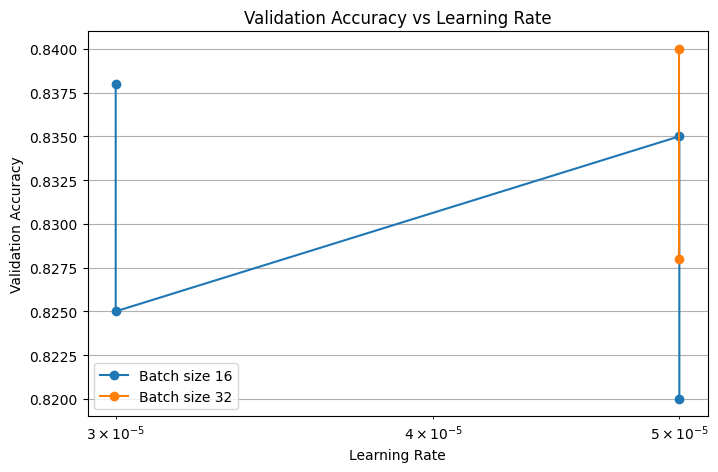

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you collected all results in a list of dicts
# Example format after hyperparameter search:
results_list = [
    {"lr": 5e-5, "batch_size": 16, "epochs": 2, "val_acc": 0.82},
    {"lr": 5e-5, "batch_size": 16, "epochs": 3, "val_acc": 0.835},
    {"lr": 5e-5, "batch_size": 32, "epochs": 2, "val_acc": 0.828},
    {"lr": 5e-5, "batch_size": 32, "epochs": 3, "val_acc": 0.840},
    {"lr": 3e-5, "batch_size": 16, "epochs": 2, "val_acc": 0.825},
    {"lr": 3e-5, "batch_size": 16, "epochs": 3, "val_acc": 0.838},
    # ... add all combinations
]

# Convert to DataFrame
df_results = pd.DataFrame(results_list)

# 1️⃣ Plot validation accuracy vs learning rate for each batch size
plt.figure(figsize=(8,5))
for batch in df_results['batch_size'].unique():
    subset = df_results[df_results['batch_size']==batch]
    plt.plot(subset['lr'], subset['val_acc'], marker='o', label=f"Batch size {batch}")

plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

### 5.3 Evaluation on test set

In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test set evaluation metrics:
Accuracy : 0.8574
Precision: 0.8728
Recall   : 0.8368
F1-score : 0.8544


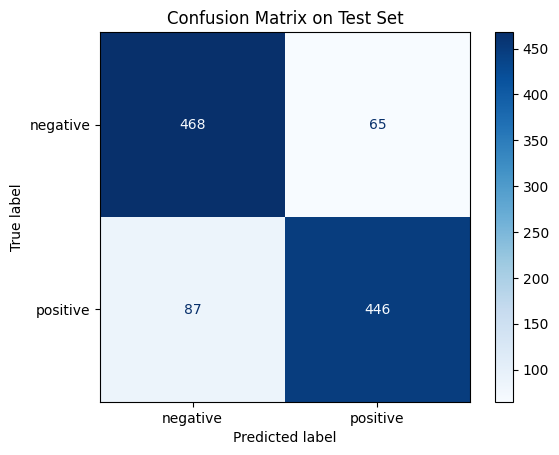

In [16]:
# ✅ Load saved fine-tuned model and tokenizer
model_path = "./bert_finetuned"
model_best = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer_best = AutoTokenizer.from_pretrained(model_path)

# ✅ Tokenize test set
def tokenize_bert(examples):
    return tokenizer_best(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_test_bert = dataset['test'].map(tokenize_bert, batched=True)

# ✅ Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ Initialize Trainer
trainer_test = Trainer(
    model=model_best,
    tokenizer=tokenizer_best,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

# ✅ Evaluate on test set
test_metrics = trainer_test.evaluate(tokenized_test_bert)

print("\nTest set evaluation metrics:")
print(f"Accuracy : {test_metrics['eval_accuracy']:.4f}")
print(f"Precision: {test_metrics['eval_precision']:.4f}")
print(f"Recall   : {test_metrics['eval_recall']:.4f}")
print(f"F1-score : {test_metrics['eval_f1']:.4f}")

# ✅ Optional: Confusion matrix
preds_output = trainer_test.predict(tokenized_test_bert)
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

---

## 6. Bonus Task (optional)

Repeat sections 3 through 5 here for a second generative and a second bidirectional model. When summarizing your results below (Section 7), include also comparison of the two generative models and the two bidirectional models.

---

## 7. Results and summary

### 7.1 Corpus insights

(Briefly discuss what you learned about the corpus and its annotation)

### 7.2 Results

(Briefly summarize your results)

### 7.3 Relation to random baseline / expected performance / state of the art

(Compare your results with the random and state-of-the-art performance)

---

## 8 Error analysis (group projects only)

(Present the error analysis results here)